In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from statsmodels.graphics.factorplots import interaction_plot
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
from statsmodels.stats.power import TTestIndPower, TTestPower
import warnings
warnings.filterwarnings('ignore')
import scipy as sp

# Connecting to the Northwind Database

In [2]:
con = sqlite3.connect('Northwind_small.sqlite', detect_types=sqlite3.PARSE_COLNAMES )
cur = con.cursor()

In [3]:
#create list of tables
cur.execute("""SELECT name from sqlite_master WHERE type = 'table';""")
tables = cur.fetchall()
tables = [i[0] for i in tables]

# Visualization of the Northwind Database Schema

In [5]:
from IPython.display import Image
from IPython.display import HTML
Image(url = "https://raw.githubusercontent.com/learn-co-students/dsc-mod-3-project-london-ds-111819/master/Northwind_ERD.png")



In [6]:

cur.execute("""SELECT name
               FROM sqlite_master
               WHERE type = 'table'
               ORDER BY name
;""").fetchall()

[('Category',),
 ('Customer',),
 ('CustomerCustomerDemo',),
 ('CustomerDemographic',),
 ('Employee',),
 ('EmployeeTerritory',),
 ('Order',),
 ('OrderDetail',),
 ('Product',),
 ('Region',),
 ('Shipper',),
 ('Supplier',),
 ('Territory',)]

In [7]:
cur.execute("""SELECT *FROM sqlite_master WHERE type = 'table';""")
df = pd.DataFrame(cur.fetchall())
df.columns = [i[0] for i in cur.description]
df

,type,name,tbl_name,rootpage,sql
0,table,Employee,Employee,2,"CREATE TABLE ""Employee"" \n(\n ""Id"" INTEGER PR..."
1,table,Category,Category,3,"CREATE TABLE ""Category"" \n(\n ""Id"" INTEGER PR..."
2,table,Customer,Customer,4,"CREATE TABLE ""Customer"" \n(\n ""Id"" VARCHAR(80..."
3,table,Shipper,Shipper,8,"CREATE TABLE ""Shipper"" \n(\n ""Id"" INTEGER PRI..."
4,table,Supplier,Supplier,9,"CREATE TABLE ""Supplier"" \n(\n ""Id"" INTEGER PR..."
5,table,Order,Order,11,"CREATE TABLE ""Order"" \n(\n ""Id"" INTEGER PRIMA..."
6,table,Product,Product,12,"CREATE TABLE ""Product"" \n(\n ""Id"" INTEGER PRI..."
7,table,OrderDetail,OrderDetail,14,"CREATE TABLE ""OrderDetail"" \n(\n ""Id"" VARCHAR..."
8,table,CustomerCustomerDemo,CustomerCustomerDemo,16,"CREATE TABLE ""CustomerCustomerDemo"" \n(\n ""Id..."
9,table,CustomerDemographic,CustomerDemographic,18,"CREATE TABLE ""CustomerDemographic"" \n(\n ""Id""..."


# For loop to convert SQL into Pandas DataFrame

In [8]:
tables = cur.execute("SELECT name FROM sqlite_master WHERE type='table';").fetchall()
tables = [i[0] for i in tables]

In [16]:
dfs = []
for i in tables:
    table = cur.execute('SELECT * FROM "'+i+'" ' ).fetchall()
    columns = cur.execute('PRAGMA table_info("'+i+'")').fetchall()
    df = pd.DataFrame(table, columns=[i[1] for i in columns])
    foo = i+"_df" # to make a string into a variable name
    exec(foo + " = df") # to make TableName_df
    dfs.append(foo)

In [17]:
dfs

['Employee_df',
 'Category_df',
 'Customer_df',
 'Shipper_df',
 'Supplier_df',
 'Order_df',
 'Product_df',
 'OrderDetail_df',
 'CustomerCustomerDemo_df',
 'CustomerDemographic_df',
 'Region_df',
 'Territory_df',
 'EmployeeTerritory_df']

In [103]:
df_tables = [Employee_df,
 Category_df,
 Customer_df,
 Shipper_df,
 Supplier_df,
 Order_df,
 Product_df,
 OrderDetail_df,
 CustomerCustomerDemo_df,
 CustomerDemographic_df,
 Region_df,
 Territory_df,
 EmployeeTerritory_df]

In [104]:
 for item in df_tables:
        display(item.head())

,Id,LastName,FirstName,Title,TitleOfCourtesy,BirthDate,HireDate,Address,City,Region,PostalCode,Country,HomePhone,Extension,Photo,Notes,ReportsTo,PhotoPath
0,1,Davolio,Nancy,Sales Representative,Ms.,1980-12-08,2024-05-01,507 - 20th Ave. E. Apt. 2A,Seattle,North America,98122,USA,(206) 555-9857,5467,None,Education includes a BA in psychology from Col...,2.0,http://accweb/emmployees/davolio.bmp
1,2,Fuller,Andrew,"Vice President, Sales",Dr.,1984-02-19,2024-08-14,908 W. Capital Way,Tacoma,North America,98401,USA,(206) 555-9482,3457,None,Andrew received his BTS commercial in 1974 and...,NaN,http://accweb/emmployees/fuller.bmp
2,3,Leverling,Janet,Sales Representative,Ms.,1995-08-30,2024-04-01,722 Moss Bay Blvd.,Kirkland,North America,98033,USA,(206) 555-3412,3355,None,Janet has a BS degree in chemistry from Boston...,2.0,http://accweb/emmployees/leverling.bmp
3,4,Peacock,Margaret,Sales Representative,Mrs.,1969-09-19,2025-05-03,4110 Old Redmond Rd.,Redmond,North America,98052,USA,(206) 555-8122,5176,None,Margaret holds a BA in English literature from...,2.0,http://accweb/emmployees/peacock.bmp
4,5,Buchanan,Steven,Sales Manager,Mr.,1987-03-04,2025-10-17,14 Garrett Hill,London,British Isles,SW1 8JR,UK,(71) 555-4848,3453,None,Steven Buchanan graduated from St. Andrews Uni...,2.0,http://accweb/emmployees/buchanan.bmp


,Id,CategoryName,Description
0,1,Beverages,"Soft drinks, coffees, teas, beers, and ales"
1,2,Condiments,"Sweet and savory sauces, relishes, spreads, an..."
2,3,Confections,"Desserts, candies, and sweet breads"
3,4,Dairy Products,Cheeses
4,5,Grains/Cereals,"Breads, crackers, pasta, and cereal"


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax
0,ALFKI,Alfreds Futterkiste,Maria Anders,Sales Representative,Obere Str. 57,Berlin,Western Europe,12209,Germany,030-0074321,030-0076545
1,ANATR,Ana Trujillo Emparedados y helados,Ana Trujillo,Owner,Avda. de la Constitución 2222,México D.F.,Central America,05021,Mexico,(5) 555-4729,(5) 555-3745
2,ANTON,Antonio Moreno Taquería,Antonio Moreno,Owner,Mataderos 2312,México D.F.,Central America,05023,Mexico,(5) 555-3932,None
3,AROUT,Around the Horn,Thomas Hardy,Sales Representative,120 Hanover Sq.,London,British Isles,WA1 1DP,UK,(171) 555-7788,(171) 555-6750
4,BERGS,Berglunds snabbköp,Christina Berglund,Order Administrator,Berguvsvägen 8,Luleå,Northern Europe,S-958 22,Sweden,0921-12 34 65,0921-12 34 67


,Id,CompanyName,Phone
0,1,Speedy Express,(503) 555-9831
1,2,United Package,(503) 555-3199
2,3,Federal Shipping,(503) 555-9931


,Id,CompanyName,ContactName,ContactTitle,Address,City,Region,PostalCode,Country,Phone,Fax,HomePage
0,1,Exotic Liquids,Charlotte Cooper,Purchasing Manager,49 Gilbert St.,London,British Isles,EC1 4SD,UK,(171) 555-2222,None,None
1,2,New Orleans Cajun Delights,Shelley Burke,Order Administrator,P.O. Box 78934,New Orleans,North America,70117,USA,(100) 555-4822,None,#CAJUN.HTM#
2,3,Grandma Kelly's Homestead,Regina Murphy,Sales Representative,707 Oxford Rd.,Ann Arbor,North America,48104,USA,(313) 555-5735,(313) 555-3349,None
3,4,Tokyo Traders,Yoshi Nagase,Marketing Manager,9-8 Sekimai Musashino-shi,Tokyo,Eastern Asia,100,Japan,(03) 3555-5011,None,None
4,5,Cooperativa de Quesos 'Las Cabras',Antonio del Valle Saavedra,Export Administrator,Calle del Rosal 4,Oviedo,Southern Europe,33007,Spain,(98) 598 76 54,None,None


,Id,CustomerId,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,Freight,ShipName,ShipAddress,ShipCity,ShipRegion,ShipPostalCode,ShipCountry
0,10248,VINET,5,2012-07-04,2012-08-01,2012-07-16,3,32.38,Vins et alcools Chevalier,59 rue de l'Abbaye,Reims,Western Europe,51100,France
1,10249,TOMSP,6,2012-07-05,2012-08-16,2012-07-10,1,11.61,Toms Spezialitäten,Luisenstr. 48,Münster,Western Europe,44087,Germany
2,10250,HANAR,4,2012-07-08,2012-08-05,2012-07-12,2,65.83,Hanari Carnes,"Rua do Paço, 67",Rio de Janeiro,South America,05454-876,Brazil
3,10251,VICTE,3,2012-07-08,2012-08-05,2012-07-15,1,41.34,Victuailles en stock,"2, rue du Commerce",Lyon,Western Europe,69004,France
4,10252,SUPRD,4,2012-07-09,2012-08-06,2012-07-11,2,51.30,Suprêmes délices,"Boulevard Tirou, 255",Charleroi,Western Europe,B-6000,Belgium


,Id,ProductName,SupplierId,CategoryId,QuantityPerUnit,UnitPrice,UnitsInStock,UnitsOnOrder,ReorderLevel,Discontinued
0,1,Chai,1,1,10 boxes x 20 bags,18.00,39,0,10,0
1,2,Chang,1,1,24 - 12 oz bottles,19.00,17,40,25,0
2,3,Aniseed Syrup,1,2,12 - 550 ml bottles,10.00,13,70,25,0
3,4,Chef Anton's Cajun Seasoning,2,2,48 - 6 oz jars,22.00,53,0,0,0
4,5,Chef Anton's Gumbo Mix,2,2,36 boxes,21.35,0,0,0,1


,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


,Id,CustomerTypeId


,Id,CustomerDesc


,Id,RegionDescription
0,1,Eastern
1,2,Western
2,3,Northern
3,4,Southern


,Id,TerritoryDescription,RegionId
0,01581,Westboro,1
1,01730,Bedford,1
2,01833,Georgetow,1
3,02116,Boston,1
4,02139,Cambridge,1


,Id,EmployeeId,TerritoryId
0,1/06897,1,06897
1,1/19713,1,19713
2,2/01581,2,01581
3,2/01730,2,01730
4,2/01833,2,01833


In [20]:
#Now that we have everything in Pandas we can perform some data manipulations this way
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [21]:
OrderDetail_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


In [22]:
OrderDetail_df.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [23]:
OrderDetail_df.ProductId.nunique()

77

In [24]:
OrderDetail_df.OrderId.nunique()

830

In [ ]:
# discount['Discount_Value'] = discount['UnitPrice'] * OrderDetail_df['Quantity'] * (1 - Discount

# Now lets look for Orders with Discount

In [105]:
discount = OrderDetail_df.loc[(OrderDetail_df['Discount'] != 0 )]
discount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


In [106]:
discount['Discount_Value'] = discount['UnitPrice'] * discount['Quantity'] * (1 - discount['Discount'])

# Now Lets Look At The Rows Without Discount

In [107]:
nodiscount = OrderDetail_df.loc[(OrderDetail_df['Discount'] == 0)]
nodiscount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [ ]:
Sum(Discount * quantity * UnitPrice) AS Discount_Value

In [108]:
nodiscount['Discount_Value'] = nodiscount['UnitPrice'] * nodiscount['Quantity']  

In [109]:
nodiscount.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount,Discount_Value
0,10248/11,10248,11,14.0,12,0.0,168.0
1,10248/42,10248,42,9.8,10,0.0,98.0
2,10248/72,10248,72,34.8,5,0.0,174.0
3,10249/14,10249,14,18.6,9,0.0,167.4
4,10249/51,10249,51,42.4,40,0.0,1696.0


In [110]:
nodiscountByProductId = nodiscount.groupby("ProductId").Quantity.sum()
nodiscountByProductId.head()

ProductId
1    391
2    408
3    288
4    172
5    176
Name: Quantity, dtype: int64

# Now lets check the discount DataFrame

In [ ]:
discount.head()

In [ ]:
discountByProductId = discount.groupby('Quantity')
discountByProductId.head()

In [ ]:
#lets have a look at the different levels of discount And How many times they are used
discount['Discount'].unique()

In [ ]:
# columns = 'Id' ,'CompanyName' ,'ContactName' ,'ContactTitle' ,'Address' ,'City','Region','PostalCode','Country'
# dfCustDetails = pd.DataFrame(dfCustomerDetails , columns = columns)

# starts here

In [25]:
OrderDetail_df.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [26]:
discount = OrderDetail_df[OrderDetail_df.Discount > 0]['Quantity']
discount.head()

6     35
7     15
8      6
9     15
11    40
Name: Quantity, dtype: int64

In [27]:
discount2 = OrderDetail_df[OrderDetail_df.Discount > 0].copy()
discount2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


In [28]:
discount.describe()

count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

In [29]:
no_discount = OrderDetail_df[OrderDetail_df.Discount == 0]['Quantity']
no_discount.head()

0    12
1    10
2     5
3     9
4    40
Name: Quantity, dtype: int64

In [30]:
no_discount2 = OrderDetail_df[OrderDetail_df.Discount == 0].copy()
no_discount2.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [31]:
no_discount.describe()

count    1317.000000
mean       21.715262
std        17.507493
min         1.000000
25%        10.000000
50%        18.000000
75%        30.000000
max       130.000000
Name: Quantity, dtype: float64

In [32]:
# No_discount mean
mu_no_discount = no_discount.mean()

# Discount mean
mu_discount = discount.mean()

# Sample size (n)
n = len(discount)

# Degrees of Freedom
df = n-1

# Sample Standard Deviation (sigma) using Numpy
std_discount = np.std(discount)

# Difference in means
diff = mu_discount - mu_no_discount


# Print the findings
print ('The discount group contains', n, 'observations, having a Mean of', np.round(mu_discount,3), 
       "and a standard deviation = ", np.round(std_discount,3), 
       ", with", df, "degrees of freedom. The no discount group contains", len(no_discount), 
       "observations, and has a Mean of", np.round(mu_no_discount,3), "and a standard deviation = ", 
       np.round(np.std(no_discount,ddof=1),3), 
       ". The difference between discount and no_discount Mean is:", np.round(diff,3))

The discount group contains 838 observations, having a Mean of 27.11 and a standard deviation =  20.759 , with 837 degrees of freedom. The no discount group contains 1317 observations, and has a Mean of 21.715 and a standard deviation =  17.507 . The difference between discount and no_discount Mean is: 5.395


Observations : We can see that the statistical distributions of both orders with discounts and no discount
    with both having a Mean of 27 and 21 and Standard deviations of 21 and 17 respectively
    
We can also see that the total sales for discounts was 838 orders and 1317 when there was no discounts. Thus
there were more orders when discounts were not applied. However , before we jump into conclusions it could
also be that the discunts were applied on products to make way for new production , save warehousing space or
these were products that had limited supply or we just wanted to get rid of products that were not selling
that much thus we applied discounts.

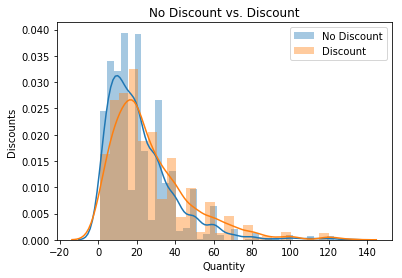

In [33]:
#How does the distribution of no discount look overlaid with the distribution of discount?
plt.title("No Discount vs. Discount")
sns.distplot(no_discount, label='No Discount') 
sns.distplot(discount, label='Discount')
plt.xlabel("Quantity")
plt.ylabel('Discounts')
plt.legend()
plt.show()

# Observations from Visualization

The mean of the discount group is higher than the no discount group, and the distribution of the discount group does appear to be to the right (high quantity) of the no discount group. But is this difference significant?

# Probability Density Function

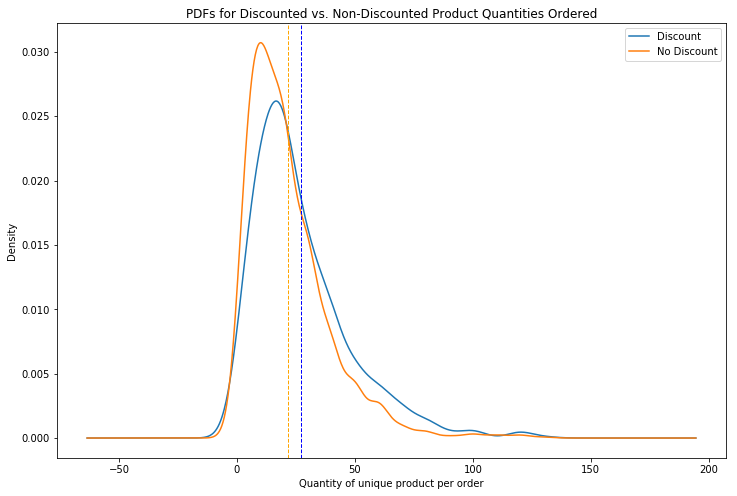

In [34]:
plt.figure(figsize=(12,8))
discount2.Quantity.plot.kde(label="Discount")
no_discount2.Quantity.plot.kde(label="No Discount")
plt.title("PDFs for Discounted vs. Non-Discounted Product Quantities Ordered")
plt.xlabel('Quantity of unique product per order')
plt.legend()
plt.axvline(discount2.Quantity.mean(), color='blue', linestyle='dashed', linewidth=1)
plt.axvline(no_discount2.Quantity.mean(), color="orange", linestyle="dashed", linewidth=1)
plt.show()

# Observations : 
In the above I have treated Discount as a continuous variable . Thus using the Probability density function.
Note : In some cases discounts can be seen as discrete variables in some cases

# Hypothesis Testing 

# Does Discount Matter?

One Tail Hypothesis Test - Does Discount Matter?
Step 1: Write the null and alternative hypothesis statements

$H_{0}$ : There is no relationship between quantity and discount, i.e. mean number sold with a discount <= mean sold without a discount.

mu_discount <= mu_nodiscount ---> mu_discount <= 21.72

$H_{1}$ : There is a relationship between quanity and discount, i.e. mean number sold with a discount > mean sold without a discount.

mu_discount > mu_nodiscount ---> mu_discount > 21.72
Step 2: Choose a significance level (α)
α is the probability of rejecting the null hypothesis when it is true. I will use the standard significance level of α = 0.05, meaning that there is a 5% chance of concluding that a difference exists when there is no actual difference.

Step 3: Calculate the t-statistic
Formula for one-sample t-test given as:

$$t = \frac{\bar{x}-\mu}{\frac{s}{\sqrt{n}}}$$

Using the formula given above, calculate the t-value in Python:

scipy.stats.t.ppf(1-alpha, df)

scipy.stats.ttest_1samp(a, popmean, axis=0, nan_policy='propagate')

# Calculate critical t value

In [35]:
t_crit = np.round(stats.t.ppf(1 - 0.05, df=df),3)
print("t_critical value = ", t_crit)

t_critical value =  1.647


# Calculate t stat and p value

In [37]:
results = stats.ttest_1samp(a= discount, popmean= mu_no_discount)         
print ("The t-value for the discount group is", round(results[0], 2), "and the p-value is", (results[1]))

The t-value for the discount group is 7.52 and the p-value is 1.4308992265460746e-13


In [38]:
if (results[0]>t_crit) and (results[1]<0.05):
    print ("Reject Null hypothesis . Results are statistically significant with t-value =", 
           round(results[0], 2), "and p-value =", (results[1])," With 95% confidence, there is a relationship between discount and quantity sold - larger quantities are sold when discount is offered.")
else:
    print ("Accept Null hypothesis")

Reject Null hypothesis . Results are statistically significant with t-value = 7.52 and p-value = 1.4308992265460746e-13  With 95% confidence, there is a relationship between discount and quantity sold - larger quantities are sold when discount is offered.


# Welch's T-Test

In [39]:
discount.describe()

count    838.000000
mean      27.109785
std       20.771439
min        1.000000
25%       12.000000
50%       20.000000
75%       36.000000
max      130.000000
Name: Quantity, dtype: float64

# Step in Calculating in Welches T-Test

In [40]:
np.var(discount)

430.93782787748984

In [41]:
np.var(no_discount)

306.2795924332757


The discount and no discount groups are not the same size, so it is much better to use the welch's t test.

$ \Large t = \frac{\bar{X_1}-\bar{X_2}}{\sqrt{\frac{s_1^2}{N_1} + \frac{s_2^2}{N_2}}} = \frac{\bar{X_1}-\bar{X_2}}{\sqrt{se_1^2+se_2^2}}$ where

$\bar{X_i}$ - mean of sample i
$s_i^2$ - variance of sample i
$N_i$ - sample size of sample i

In [42]:
def welch_t(a, b):
    
    """ Calculate Welch's t statistic for two samples. """

    numerator = a.mean() - b.mean()
    
    # “ddof = Delta Degrees of Freedom”: the divisor used in the calculation is N - ddof, 
    #  where N represents the number of elements. By default ddof is zero.
    
    denominator = np.sqrt(a.var(ddof=1)/a.size + b.var(ddof=1)/b.size)
    
    return np.abs(numerator/denominator)

welch_t(no_discount, discount)

6.239069142123973

Now that we have the t-score, we also need to calculate the Degrees of freedom to determine the appropriate t-distribution and convert this score into a p-value. The effective degrees of freedom can be calculated using the formula:

$ \Large v \approx \frac{\left( \frac{s_1^2}{N_1} + \frac{s_2^2}{N_2}\right)^2}{\frac{s_1^4}{N_1^2v_1} + \frac{s_2^4}{N_2^2v_2}} $

In [43]:
def welch_df(a, b):
    
    """ Calculate the effective degrees of freedom for two samples. """
    
    s1 = a.var(ddof=1) 
    s2 = b.var(ddof=1)
    n1 = a.size
    n2 = b.size
    
    numerator = (s1/n1 + s2/n2)**2
    denominator = (s1/ n1)**2/(n1 - 1) + (s2/ n2)**2/(n2 - 1)
    
    return numerator/denominator

welch_df(no_discount, discount)

1561.7678231942148

In [163]:
t = welch_t(no_discount, discount)
df = welch_df(no_discount, discount)
print("t-stat =",t, "degrees of freedom =",df)

t-stat = OrderId           3410.595125
ProductId           32.271752
UnitPrice            7.363882
Quantity             9.747405
Discount            44.713103
Discount_Value      46.242885
dtype: float64 degrees of freedom = OrderId           6139.860064
ProductId         2352.962584
UnitPrice         3303.449748
Quantity          2229.269634
Discount          1316.009941
Discount_Value    5881.586366
dtype: float64


# Using the cumulative distribution function associated with t-distribution: p value will be 1 - area under the curve calculated for given t and df


In [45]:
def p_value(a, b, two_sided=False):

    t = welch_t(a, b)
    df = welch_df(a, b)
    
    p = 1-stats.t.cdf(np.abs(t), df)
    
    if two_sided:
        return 2*p
    else:
        return p

In [46]:
welch_result = p_value(no_discount, discount)
print("p-value =",welch_result)

p-value = 2.8282065578366655e-10


In [47]:
if  (welch_result < 0.05):
    print ("Welch's t-test: Null hypothesis rejected. Results are statistically significant with t-value =", 
           round(t, 3), "and p-value =", welch_result,". I conclude with 95% confidence that there is a relationship between discount and quantity sold - Thus larger quantities are sold when a discount is offered.")
else:
    print ("Null hypothesis is Accepted")

Welch's t-test: Null hypothesis rejected. Results are statistically significant with t-value = 6.239 and p-value = 2.8282065578366655e-10 . I conclude with 95% confidence that there is a relationship between discount and quantity sold - Thus larger quantities are sold when a discount is offered.


Cohen's $d$
Cohen’s D is a common ways to measure effect size. Cohen's d is typically used to represent the magnitude of differences between two (or more) groups on a given variable, with larger values representing a greater differentiation between the two groups.

The basic formula to calculate Cohen’s $d$ is:

$d$ = effect size (difference of means) / pooled standard deviation

$ d = \frac{m_1 - m_2}{s}$, where m_1 and m_2 are the respective sample means and s is the (overall) standard deviation

The denominator is the standardiser, and it is important to select the most appropriate one for a given dataset. The pooled standard deviation is the average spread of all data points around their group mean (not the overall mean).

In [48]:
def Cohen_d(group1, group2):

    # Compute Cohen's d.

    # group1: Series or NumPy array
    # group2: Series or NumPy array

    # returns a floating point number 

    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    # Calculate the pooled variance
    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    
    # Calculate Cohen's d statistic
    d = diff / np.sqrt(pooled_var)
    
    return d

In [49]:
Cohen_d(discount, no_discount)

0.2862724481729282

# Effect Size

We will calculate Cohen's D to assess whether the difference in the sample parameters is considered a small, medium, or large effect


In [50]:
print("Cohen's d: {}".format (Cohen_d(discount, no_discount)))

Cohen's d: 0.2862724481729282


# Cohen's d Rule

Interpreting $d$
Interpreting the result of Cohen’s D means, use these general “rule of thumb” guidelines (which Cohen said should be used cautiously):

Small effect = 0.2

Medium Effect = 0.5

Large Effect = 0.8

Conclusion
Using an alpha of 0.05, I conclude with 95% confidence that discount does matter in terms of quantity sold. Higher quantities are sold when a discount is applied. While the difference between quantity sold with a discount vs. without a discount is statistically significant, the Cohen's $d$ comparing quantity sold at a discount vs. no discount = 0.286, suggests that the effect of a discount is small.

# Quetion 2 : Does Discount Affect Quantity Sold and if yes at what levels

# Visualization function for comparing two samples

In [142]:
def visualization(control, experimental):
    plt.figure(figsize=(12,8))
    sns.distplot(experimental, bins=50, label="Experimental")
    sns.distplot(control, bins=50, label="Control")
    # add lines for sample means - adjust if different parameter is being tested
    plt.axvline(x=control.mean(), color='k', linestyle='--')
    plt.axvline(x=experimental.mean(), color='k', linestyle='--')
    
    plt.title("Control vs. Experimental Sample Distributions", fontsize=14)
    plt.xlabel('Distribution of Total Quantiy of Sales')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

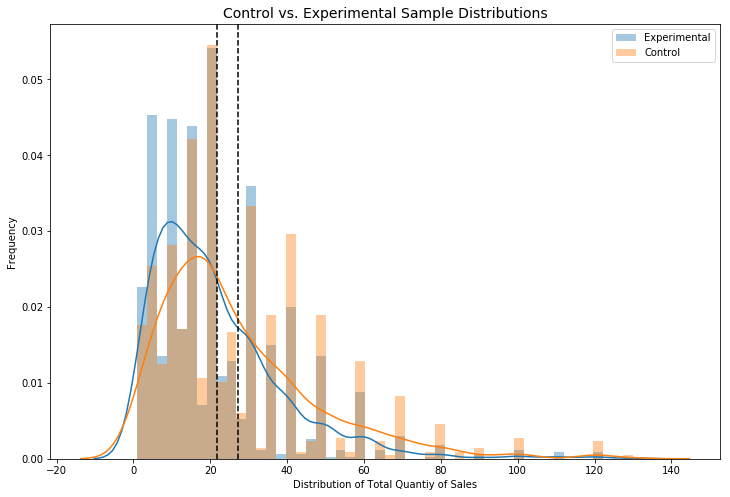

In [143]:
visualization(discount2.Quantity, no_discount2.Quantity)


Q2b: If so, at what level(s) of discount?
In order to determine at which level(s) of discount we can see a statistically significant difference in quantity ordered, we need to perform a one-way ANOVA test using discount levels as a categorical variable.

# Showing descriptive stats for Quantity ordered at each discount level provided

In [53]:
OrderDetail_df['Quantity'].groupby(OrderDetail_df['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


In [54]:
uniqueDiscount = OrderDetail_df['Discount'].unique()
uniqueDiscount

array([0.  , 0.15, 0.05, 0.2 , 0.25, 0.1 , 0.02, 0.03, 0.04, 0.06, 0.01])

# Lets Plot the different levels of discounts

In [ ]:
#run this in Pandas instead of SQL to get quantity sold at each discount level

In [121]:
cur.execute("""SELECT Discount, sum(Quantity) as Quantity , Count(Discount)
                            FROM OrderDetail
                            GROUP BY Discount
                            ORDER BY Discount
        
                            ;""")
dfDiscountLevelsVSQty = pd.DataFrame(cur.fetchall())
dfDiscountLevelsVSQty.columns = [x[0] for x in cur.description]
dfDiscountLevelsVSQty.head()


,Discount,Quantity,Count(Discount)
0,0.00,28599,1317
1,0.01,2,1
2,0.02,4,2
3,0.03,5,3
4,0.04,1,1


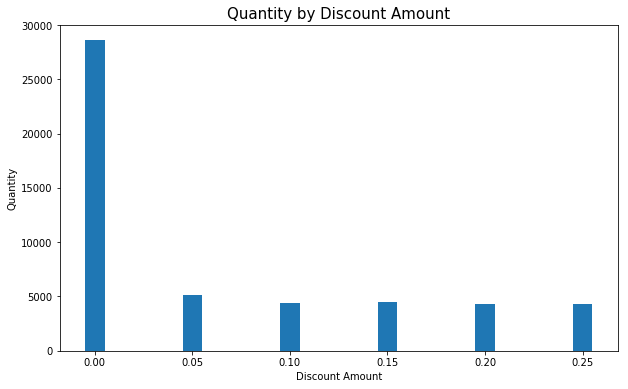

In [120]:
plt.figure(figsize=(10,6))
plt.bar(dfDiscountLevelsVSQty.Discount, dfDiscountLevelsVSQty.Quantity, width=0.01) 
plt.title('Quantity by Discount Amount', size=15)
plt.xlabel("Discount Amount")
plt.ylabel("Quantity")
plt.show()

# groupby discount one on sum of quantity and the other one count of quantity and plot the graph and compare
# with the graph

<Figure size 720x432 with 0 Axes>

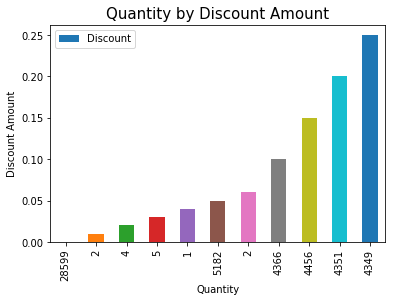

In [122]:
plt.figure(figsize=(10,6))
dfDiscountLevelsVSQty.plot(kind = 'bar' ,  x = 'Quantity', y = 'Discount') 
plt.title('Quantity by Discount Amount', size=15)
plt.xlabel("Quantity")
plt.ylabel("Discount Amount")
plt.show()

# Doing the opposite to Quantity at Different levels of Discounts

<Figure size 720x432 with 0 Axes>

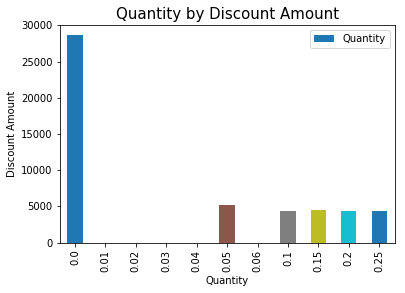

In [123]:
plt.figure(figsize=(10,6))
dfDiscountLevelsVSQty.plot(kind = 'bar' ,  x = 'Discount', y = 'Quantity') 
plt.title('Quantity by Discount Amount', size=15)
plt.xlabel("Quantity")
plt.ylabel("Discount Amount")
plt.show()

In [ ]:
#we can actually group discount levels into the most discount levels offered for Orders

In [ ]:
# collisions_by_date = df['DATE'].value_counts().reset_index()

# lets have a look at this tomorrow

Text(0.5, 1.0, 'Histogram of Daily Collision Counts')

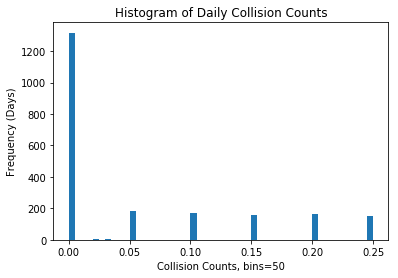

In [111]:
plt.hist(OrderDetail_df['Discount'], bins=50)
plt.xlabel('Discount Levels, bins=50')
plt.ylabel('Frequency (Days)')
plt.title('Histogram of Daily Collision Counts')
# plt.savefig('data/histogram-collisions-per-day.png')

In [56]:
VC_discounts = OrderDetail_df.Discount.value_counts()
VC_discounts

0.00    1317
0.05     185
0.10     173
0.20     161
0.15     157
0.25     154
0.03       3
0.02       2
0.01       1
0.04       1
0.06       1
Name: Discount, dtype: int64

# Lambda - Revisit this Lambda function

In [ ]:
# df_discount4 = OrderDetail_df.Discount.copy()
# df_discount4['Discount'] = OrderDetail_df['Discount'].apply(lambda x: 0.05 if (x > 0) & (x < 0.10) else x)
# df_discount4['Discount'].value_counts()

In [ ]:
df_discount4['Discounting'] = df_discount

In [61]:
#create a df that only has orders where a discount of 5% or more was applied to use for an ANOVA test to compare levels of discount
df_discount5 = OrderDetail_df[OrderDetail_df.Discount > .04]
df_discount5.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
6,10250/51,10250,51,42.4,35,0.15
7,10250/65,10250,65,16.8,15,0.15
8,10251/22,10251,22,16.8,6,0.05
9,10251/57,10251,57,15.6,15,0.05
11,10252/20,10252,20,64.8,40,0.05


In [ ]:
df_discount4.head()

In [ ]:
#Observations : We can see the most discount levels are between 5% to 25. 
## Between 1% to 6% discounts are rarely offered to clients

# Visualize OrderDetail Quantity At different Discount Levels

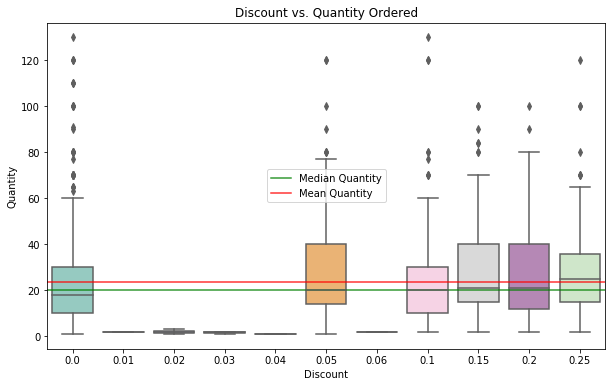

In [75]:
plt.figure(figsize=(10,6))
sns.boxplot(OrderDetail_df.Discount,OrderDetail_df.Quantity, palette = "Set3")
ax = sns.lineplot(x= range(-3,25), y= np.median(OrderDetail_df.Quantity),alpha=0.8,color='green',label='Median Quantity')
ax2 = sns.lineplot(x= range(-3,25), y= np.mean(OrderDetail_df.Quantity),alpha =0.8,color='red',label='Mean Quantity')
plt.title('Discount vs. Quantity Ordered')
plt.legend(loc='best')
plt.show()


# Observation: Median Quantity Ordered doesn't change much until the discount reaches 25%
Overall Mean Quantity Ordered is visually affected by outliers.

# Cohen's D

In [76]:
discounts_significance_df = pd.DataFrame(columns=['Discount Level','H0','Cohens D'], index=None)

discounts = [0.05, 0.1, 0.15, 0.2, 0.25]
control = OrderDetail_df[OrderDetail_df['Discount']==0]['Quantity']
for i in discounts:
    experimental = OrderDetail_df[OrderDetail_df['Discount']==i]['Quantity']
    st, p = stats.ttest_ind(control, experimental)
    d = Cohen_d(experimental, control)
    discounts_significance_df = discounts_significance_df.append( { 'Discount Level' : str(i*100)+'%' , 'H0' : 'Reject' if p < 0.025 else 'Failed', 'Cohens D' : d } , ignore_index=True)    

print('Table 1:') 
discounts_significance_df

Table 1:


,Discount Level,H0,Cohens D
0,5.0%,Reject,0.346877
1,10.0%,Reject,0.195942
2,15.0%,Reject,0.372404
3,20.0%,Reject,0.300712
4,25.0%,Reject,0.366593


# Analysis of Variance (ANOVA) - Is There a Difference Between the Levels of Discount?
Is there a difference between in quantity sold at different levels of discount?

$H_{0}$ : There is no relationship between quantity and level of discount, i.e. mean number sold is the same at each level


$H_{1}$ : There is a relationship between quanity and level of discount, i.e. mean number sold differ by level of discount



In [77]:
#is there a difference between all different discounts?
import statsmodels.api as sm
from statsmodels.formula.api import ols

formula = 'Quantity ~ C(Discount)'
lm = ols(formula, df_discount5).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                    sum_sq     df         F   PR(>F)
C(Discount)    1801.580295    5.0  0.837901  0.52289
Residual     354768.342690  825.0       NaN      NaN


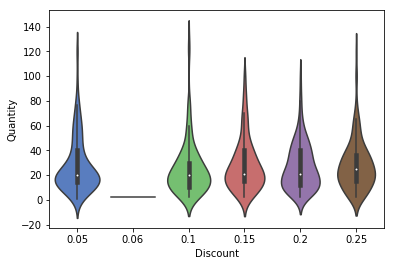

In [78]:
ax = sns.violinplot(x="Discount", y="Quantity",
                    data=df_discount5, palette="muted", split=True)

# Summary
1) Discount increases quantity sold

    - t-value = 7.52 
    - p-value = 1.4308992265460746e-13
    - alpha = 0.05
    - Cohen's d = 0.286

2) Level of discount doesn’t matter

    - alpha = 0.05
    - ANOVA F stat > 0.05

# Second Hypothesis

# Question3 - Does Employee Performance Differ? Lets check and compare employee performance between UK AND USA EMPLOYEES

$H_{0}$ : UK Employees tend to have higher orders than employees from USA
    
$H_{1}$ :  USA Employees tned to have higher orders than employees from UK  

In [ ]:
Employee_df.head()

# With this Analysis i decided to use SQL since its much quicker and mathematically much more efficient

In [ ]:
# Employee_df['UK&USA'] = Employee_df.loc[(Employee_df('Country') == UK | USA]

In [ ]:
Employee_df.loc[Employee_df()]

In [ ]:
#group employee names by employee Id to prevent future clash

In [79]:
cur.execute("""Select (LastName) AS Salesperson, Employee.Country , 
               Sum((UnitPrice * Quantity) * (1 - Discount) / 100) * 100 AS Total_Sales
               From Employee
               INNER JOIN [Order]
               ON Employee.Id = [Order].EmployeeId
               INNER JOIN OrderDetail
               ON [Order].Id = OrderDetail.OrderId
               Group By Salesperson , Employee.Country

;""")
dfSalesByCountry = pd.DataFrame(cur.fetchall())
dfSalesByCountry.columns = [x[0] for x in cur.description]
dfSalesByCountry.head()


,Salesperson,Country,Total_Sales
0,Buchanan,UK,68792.2825
1,Callahan,USA,126862.2775
2,Davolio,USA,192107.6045
3,Dodsworth,UK,77308.0665
4,Fuller,USA,166537.7550


# With this Analysis , its best to group by EmployeeId since its unique to each Emloyee. In real life some

# Employees might share the same first names ,last names or even both , thus its best to group always by EmployeeId

# Also in the case when there are new employees this also avoids further future name clashes.

In [125]:
cur.execute("""Select EmployeeId, (LastName) As Salesperson, Employee.Country , 
               Sum((UnitPrice * Quantity) * (1 - Discount) / 100) * 100 AS Total_Sales
               From Employee
               INNER JOIN [Order]
               ON Employee.Id = [Order].EmployeeId
               INNER JOIN OrderDetail
               ON [Order].Id = OrderDetail.OrderId
               Group By EmployeeId ,Salesperson , Employee.Country

;""")
dfSalesByCountry2 = pd.DataFrame(cur.fetchall())
dfSalesByCountry2.columns = [x[0] for x in cur.description]
dfSalesByCountry2.head()


,EmployeeId,Salesperson,Country,Total_Sales
0,1,Davolio,USA,192107.6045
1,2,Fuller,USA,166537.7550
2,3,Leverling,USA,202812.8430
3,4,Peacock,USA,232890.8460
4,5,Buchanan,UK,68792.2825


In [80]:
EmployeeSales  = dfSalesByCountry.groupby('Salesperson').Total_Sales.sum()
EmployeeSales

Salesperson
Buchanan      68792.2825
Callahan     126862.2775
Davolio      192107.6045
Dodsworth     77308.0665
Fuller       166537.7550
King         124568.2350
Leverling    202812.8430
Peacock      232890.8460
Suyama        73913.1295
Name: Total_Sales, dtype: float64

In [81]:
EmployeeSales2  = dfSalesByCountry.groupby(['Salesperson' , 'Country']).Total_Sales.sum()
EmployeeSales2

Salesperson  Country
Buchanan     UK          68792.2825
Callahan     USA        126862.2775
Davolio      USA        192107.6045
Dodsworth    UK          77308.0665
Fuller       USA        166537.7550
King         UK         124568.2350
Leverling    USA        202812.8430
Peacock      USA        232890.8460
Suyama       UK          73913.1295
Name: Total_Sales, dtype: float64

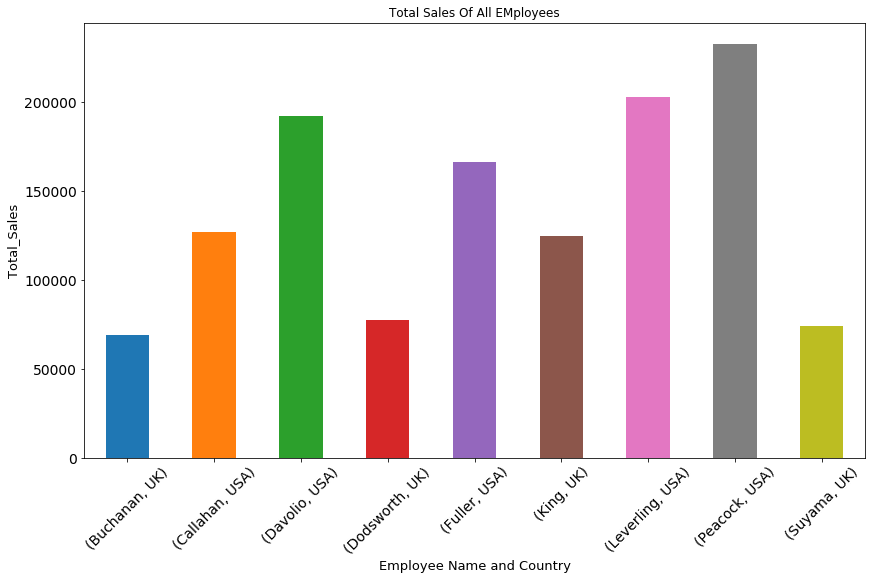

In [134]:
EmployeeSales2.plot(kind = 'bar' , figsize=(14,8) , fontsize = 14 ,rot=45)
plt.xlabel("Employee Name and Country" , fontsize = 13)
plt.ylabel("Total_Sales" , fontsize = 13)
plt.title("Total Sales Of All EMployees")
plt.show()


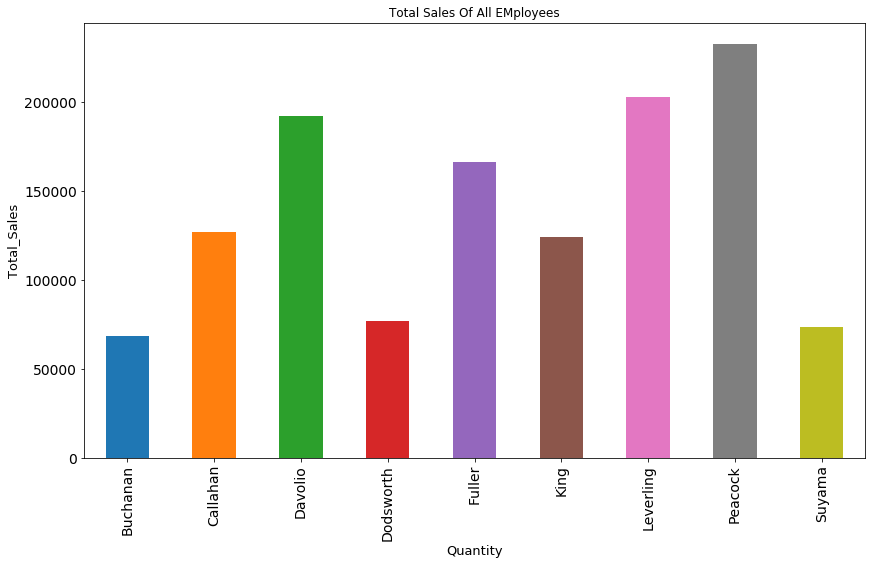

In [83]:
EmployeeSales.plot(kind = 'bar' , figsize=(14,8) , fontsize = 14)
plt.xlabel("Quantity" , fontsize = 13)
plt.ylabel("Total_Sales" , fontsize = 13)
plt.title("Total Sales Of All EMployees")
plt.show()

In [84]:
EmployeeSales2

Salesperson  Country
Buchanan     UK          68792.2825
Callahan     USA        126862.2775
Davolio      USA        192107.6045
Dodsworth    UK          77308.0665
Fuller       USA        166537.7550
King         UK         124568.2350
Leverling    USA        202812.8430
Peacock      USA        232890.8460
Suyama       UK          73913.1295
Name: Total_Sales, dtype: float64

In [85]:
EmployeeSalesByCountry = dfSalesByCountry.groupby("Country").Total_Sales.sum()

In [86]:
EmployeeSalesByCountry

Country
UK     344581.7135
USA    921211.3260
Name: Total_Sales, dtype: float64

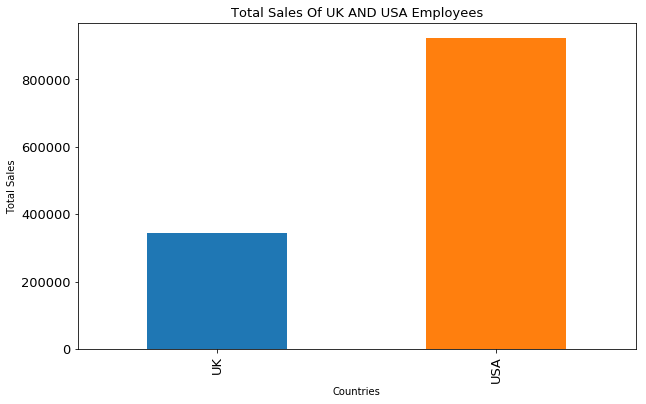

In [87]:
EmployeeSalesByCountry.plot(kind='bar' ,figsize = (10,6) ,fontsize = 13)
plt.xlabel("Countries")
plt.ylabel("Total Sales")
plt.title("Total Sales Of UK AND USA Employees" , fontsize =13)
plt.show()

In [ ]:
Observations : Here we can see with this visualization that Employees In the USA make much more sales than in the
    UK . Morever , i will make some statistical analysis to proove this.

In [88]:
EmployeeSales2.describe()

count         9.000000
mean     140643.671056
std       61000.942334
min       68792.282500
25%       77308.066500
50%      126862.277500
75%      192107.604500
max      232890.846000
Name: Total_Sales, dtype: float64

In [ ]:
# Divid the data into two datasets, each representing each country's Total Sales

In [89]:
USA = dfSalesByCountry[dfSalesByCountry.Country == 'USA']['Total_Sales']
UK  = dfSalesByCountry[dfSalesByCountry.Country == 'UK']['Total_Sales']

# Since Sales Is A Continuous Variable We shall look at the Probability Desity Function of Total Sales

# Visualization plot of the PDFs for both samples


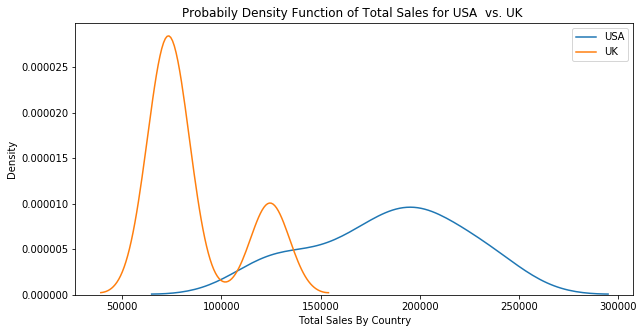

In [90]:
fig = plt.subplots(1, figsize=(10,5))
sns.kdeplot(USA,label='USA')
sns.kdeplot(UK, label='UK')
plt.xlabel('Total Sales By Country')
plt.ylabel('Density')
plt.title('Probabily Density Function of Total Sales for USA  vs. UK ')
plt.show()

We can see that both Mean(s) are pretty far apart, and the visualization shows a rather different distribution for our two samples. Another thing to point out is that the USA employees have a greater total number of orders compared to UK employees, which suggests that there is a good chance USA employees as a whole generate greater revenue than UK employees. Let's continue with hypothesis testing to determine if the Mean of the two sample are truly statistical significant and if so, see how meaningful that difference is.

# We will proceed with a t-test using an alpha value of .05 to determine if our data is statistically significant. First we need to determine which t-test to use

Test variance and sample size equality

In [91]:
print("Are Variances equal?:",np.var(USA) == np.var(UK))
print("Are Variances equal?:",np.var(UK) == len(UK))

Are Variances equal?: False
Are Variances equal?: False


Since both our variances and our sample sizes differ between the two groups, a Welch's t-test will be used. We only want to know if the USA revenue is greater than the UK revenue (we are not concerned with if it is less than), so we will use a 1 sided t-test.

# Perform 1 sided t-test indicating unequal variances with the equal_var=False parameter. Divide p-value by 2 to make this a 1 sided test.

In [92]:
result2 = stats.ttest_ind(USA,UK, equal_var = False)
print('Reject Null Hypothesis' if result2[1]/2<.05 else print('Failed to Reject Null Hypothesis'))
print('t-statistic:',result2[0],'p-value:',result2[1]/2)

Reject Null Hypothesis
t-statistic: 4.44946990483265 p-value: 0.0015960863188947472


With a low P-value of about 0.0016 ,confirms our initial confirmation that revenue generated by employees from 
USA is Significantly higher than revenue generated by UK employees. 

Lets see how meaningful are the difference by using Cohen's D to analyse effect size

# Cohen's d - Effect Size

In [93]:
Cohen_d(USA,UK)

2.8519895017550874

# Before we interpret Cohen's D , lets have a look at the Rules of Analysing Cohen's d

Interpreting $d$
Interpreting the result of Cohen’s D means, use these general “rule of thumb” guidelines (which Cohen has adviced should be used cautiously):

Small effect = 0.2

Medium Effect = 0.5

Large Effect = 0.8


2.85 indiacts a very large effect size. Therefore, we can say that when looking at the total revenue for each employee, employees in the USA generate a very significantly higher amount of revenue than do employees in the UK.

Since Our Cohen's d result is 2.85 , it means there is a very Large Effect size .
Thus we can say that employees in the USA generate a very significant amount of revenue than their fellow 
colleagues in the UK. 

Hence , we reject the Null Hypothesis $H_{0}$ : UK Employees tend to have higher orders than employees from USA
    
and Accept our Alternative Hypthesis $H_{1}$ :  USA Employees tend to have higher orders than employees from UK  

# Third Hypothesis

# Does Employee Performance Differ? Lets check and compare employee performance between UK AND USA Employees for Total Quantity of Orders


In [ ]:
#Here i am grouping into UK and USA employees for further analysis

In [94]:
usa_emp_sales = Employee_df[(Employee_df == 'USA')]
uk_emp_sales = Employee_df[(Employee_df == 'UK')]

In [ ]:
#check results

In [95]:
cur.execute("""SELECT o.employeeid, e.lastname, e.firstname, e.title, e.hiredate, e.country, 
                    COUNT(o.id) as TotalOrders 
                    FROM employee e JOIN [order] o 
                    ON o.employeeid = e.id GROUP BY o.employeeid;""")
emp_orders = pd.DataFrame(cur.fetchall())
emp_orders.columns = [x[0] for x in cur.description]
emp_orders

,EmployeeId,LastName,FirstName,Title,HireDate,Country,TotalOrders
0,1,Davolio,Nancy,Sales Representative,2024-05-01,USA,123
1,2,Fuller,Andrew,"Vice President, Sales",2024-08-14,USA,96
2,3,Leverling,Janet,Sales Representative,2024-04-01,USA,127
3,4,Peacock,Margaret,Sales Representative,2025-05-03,USA,156
4,5,Buchanan,Steven,Sales Manager,2025-10-17,UK,42
5,6,Suyama,Michael,Sales Representative,2025-10-17,UK,67
6,7,King,Robert,Sales Representative,2026-01-02,UK,72
7,8,Callahan,Laura,Inside Sales Coordinator,2026-03-05,USA,104
8,9,Dodsworth,Anne,Sales Representative,2026-11-15,UK,43


# Visualization

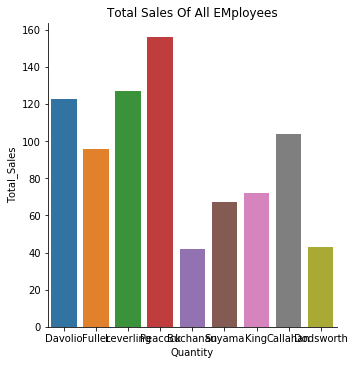

In [96]:
sns.catplot(kind = a'bar', x = 'LastName' , y='TotalOrders' , data = emp_orders)
plt.xlabel("Quantity" )
plt.ylabel("Total_Sales" )
plt.title("Total Sales Of All EMployees")
plt.show()

In [ ]:
#Visualization of Employee Performance Using Employee Id 

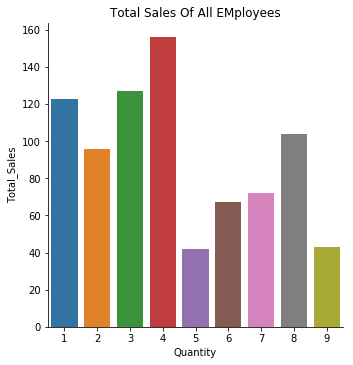

In [127]:
sns.catplot(kind = 'bar', x = 'EmployeeId' , y='TotalOrders' , data = emp_orders)
plt.xlabel("Quantity" )
plt.ylabel("Total_Sales" )
plt.title("Total Sales Of All EMployees")
plt.show()

In [97]:
usa_emp_orders = emp_orders.loc[emp_orders['Country'] == 'USA'].copy()
uk_emp_orders = emp_orders.loc[emp_orders['Country'] == 'UK'].copy()

# Two sample t-test 

In [98]:

results = stats.ttest_ind(usa_emp_orders.TotalOrders, uk_emp_orders.TotalOrders, equal_var=True)
#p-value set at 0.025
alpha = .025
if (results[0] > 0) & (results[1]/2 < alpha):
    print("Reject the null hypothesis, the avg number of orders between US and UK employees is not the same.")
else:
    print("Fail to Reject the Null Hypothesis")

Reject the null hypothesis, the avg number of orders between US and UK employees is not the same.


In [99]:
print("Two-Sample T-Test p-value: {}".format(results[1]))

Two-Sample T-Test p-value: 0.002063854331616113


# Let's perform an ANOVA test, treating Country as a category

In [100]:
formula = 'TotalOrders ~ C(Country)'
lm = ols(formula, emp_orders).fit()
table = sm.stats.anova_lm(lm, typ=2)
print(table)

                 sum_sq   df          F    PR(>F)
C(Country)  9446.755556  1.0  22.640129  0.002064
Residual    2920.800000  7.0        NaN       NaN


# Effect Size

In [101]:
print("Cohen's d (effect size): {}".format(Cohen_d(usa_emp_orders.TotalOrders, uk_emp_orders.TotalOrders)))

Cohen's d (effect size): 3.210081976551365


# Interperating Effect Size

Above, we ran both a two-sample t-test and ANOVA to understand if the difference between the performance of US versus UK employees, via total number of orders, is statistically different. Given the fact that we only have two categories (US versus UK) the ANOVA p-value and the student's t-test p-value produced are the same, as expected. 

With a P-value of 0.002 we can Reject the Null Hypothesis. The effect size is also quite large, indicated by the Cohen's d-stat of 3.2. US employees have an average order total of 121.2 orders, compared to UK employees who average 56 orders.


# Fourth Hypothesis

# Is there a difference in order processing time (from OrderDate to ShipDate) across the 3 different Shipping companies?
We will test this hypothesis out with the recognition that processing time may not be fully attributable to the Shipping company, meaning it might be the employee that acts as an intermediary between the order date and notifying the Shipping company. Given this, should there be a major difference in processing time for one or multiple shipping companies, we should dig deeper to understand the processes behind placing and order and when the shipping company is notified of the order details. We may also want to run this same processing-time-analysis against the employees responsible for each order.

$H_{0}$: - The average time from order date to ship date between the three different shipping companies is the same.

$H_{1}$: - The average time from order date to ship date between the three difference shipping companies is not the same.


$\alpha$: 0.05/3 = 0.01667 (see below)

Given the fact that we have three different shipping companies (3 samples) we must address the Multiple Comparisons Problem. We will use the Bonferroni Correction to correct for this, in an effort to minimize Type I errors.

In [144]:
cur.execute("""SELECT o.id, o.employeeid, o.orderdate, o.requireddate, o.shippeddate, o.shipvia, s.companyname 
                FROM [order] o JOIN shipper s ON o.shipvia = s.id;""")
Shipping_order = pd.DataFrame(cur.fetchall())
Shipping_order.columns = [x[0] for x in cur.description]
Shipping_order.head()

,Id,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,CompanyName
0,10248,5,2012-07-04,2012-08-01,2012-07-16,3,Federal Shipping
1,10249,6,2012-07-05,2012-08-16,2012-07-10,1,Speedy Express
2,10250,4,2012-07-08,2012-08-05,2012-07-12,2,United Package
3,10251,3,2012-07-08,2012-08-05,2012-07-15,1,Speedy Express
4,10252,4,2012-07-09,2012-08-06,2012-07-11,2,United Package


# EDA

In [145]:
#checking if the Query has any null values
Shipping_order.isnull().any()

Id              False
EmployeeId      False
OrderDate       False
RequiredDate    False
ShippedDate      True
ShipVia         False
CompanyName     False
dtype: bool

In [146]:
#Dropping Null Values
Shipping_order.dropna(inplace = True)

In [147]:
#Check Results
Shipping_order.isnull().sum()

Id              0
EmployeeId      0
OrderDate       0
RequiredDate    0
ShippedDate     0
ShipVia         0
CompanyName     0
dtype: int64

In [149]:
# change column data types for datetime, then subtract order date from shipping date to provide processing time
import datetime
Shipping_order['OrderDate'] = pd.to_datetime(Shipping_order['OrderDate'])
Shipping_order['ShippedDate'] = pd.to_datetime(Shipping_order['ShippedDate'])


# Create a new column for the processing time by simply subtracting the

# shipping order dates from order date

In [150]:
Shipping_order['ProcessingTime'] = Shipping_order['ShippedDate'] - Shipping_order['OrderDate']
Shipping_order['ProcessingTime'] = Shipping_order['ProcessingTime'].dt.days
Shipping_order.head()

,Id,EmployeeId,OrderDate,RequiredDate,ShippedDate,ShipVia,CompanyName,ProcessingTime
0,10248,5,2012-07-04,2012-08-01,2012-07-16,3,Federal Shipping,12
1,10249,6,2012-07-05,2012-08-16,2012-07-10,1,Speedy Express,5
2,10250,4,2012-07-08,2012-08-05,2012-07-12,2,United Package,4
3,10251,3,2012-07-08,2012-08-05,2012-07-15,1,Speedy Express,7
4,10252,4,2012-07-09,2012-08-06,2012-07-11,2,United Package,2


In [ ]:
# descriptive stats on processing time for each shipping company

In [151]:
Shipping_order['ProcessingTime'].groupby(Shipping_order['CompanyName']).describe()

,count,mean,std,min,25%,50%,75%,max
CompanyName,,,,,,,,
Federal Shipping,249.0,7.473896,5.680357,1.0,4.0,6.0,9.0,35.0
Speedy Express,245.0,8.571429,6.777494,1.0,5.0,7.0,9.0,37.0
United Package,315.0,9.234921,7.601671,1.0,4.0,7.0,10.0,37.0


By looking at the descriptions, the sample sizes are relatively similar and the means seem pretty close. Interestingly, as the Mean increase so does the standard deviations.

# plot each of the three processing time distributions

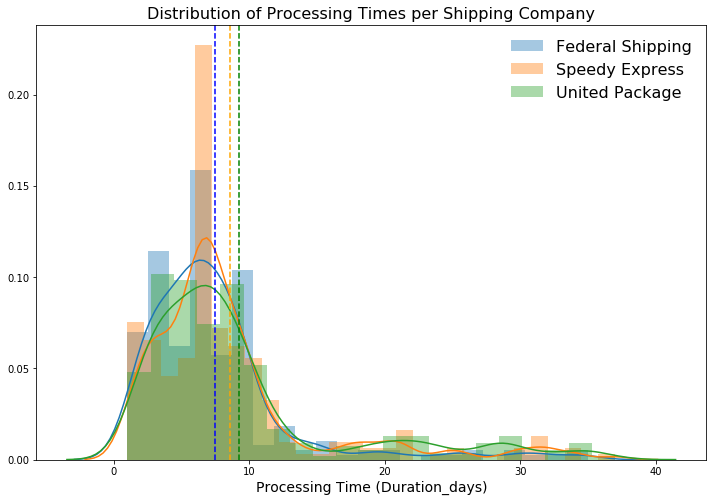

In [154]:
FedShip = Shipping_order.loc[Shipping_order['CompanyName']=='Federal Shipping']['ProcessingTime']
SpeedyExpress = Shipping_order.loc[Shipping_order['CompanyName']=='Speedy Express']['ProcessingTime']
UnitedPack = Shipping_order.loc[Shipping_order['CompanyName']=='United Package']['ProcessingTime']

plt.figure(figsize=(12, 8))
sns.distplot(FedShip, label='Federal Shipping')
sns.distplot(SpeedyExpress, label='Speedy Express')
sns.distplot(UnitedPack, label='United Package')
plt.axvline(x=FedShip.mean(), color='blue', linestyle='--')
plt.axvline(x=SpeedyExpress.mean(), color='orange', linestyle='--')
plt.axvline(x=UnitedPack.mean(), color='green', linestyle='--')
plt.title('Distribution of Processing Times per Shipping Company', fontsize=16)
plt.xlabel('Processing Time (Duration_days)', fontsize=14)

plt.legend(frameon=False, fontsize=16, loc='best')
plt.show()

We can see that all three of the distributions are skewed to the right, however each of the distributions look alike and have large sample sizes (all with n>200).

# Before any futher analysis lets look at the Variances and see if they are the same.

In [155]:
print("Variances for each company's processing time:")
print("FedShip: {} \tSpeedyExpress: {} \tUnitedPack: {}".format(np.var(FedShip), np.var(SpeedyExpress), np.var(UnitedPack)))

Variances for each company's processing time:
FedShip: 32.136868760181294 	SpeedyExpress: 45.746938775510216 	UnitedPack: 57.60195515243134


# Observations and Anova Test

We are running an ANOVA to test if there are differences  the between the shipping companies' average processing time. 
While the distributions are not normal and the variances are not equal, we have robust sampling distributions based on the sufficient sample sizes for each company's processing time. We can also assume independence amongst the response variables as well and proceed with the ANOVA test.

In [158]:
formula = 'ProcessingTime ~ C(CompanyName)'
lm = ols(formula , Shipping_order).fit()
table = sm.stats.anova_lm(lm, typ=2 )
print(table)

                      sum_sq     df         F    PR(>F)
C(CompanyName)    433.501581    2.0  4.676819  0.009563
Residual        37354.696194  806.0       NaN       NaN


Eventhough the ANOVA test allows us to determine whether there is a statistically significant difference between the Shipping Company Means, it doesn't provide insight as to which Means are different. In order to determine this, we need to perform a multiple comparisons analysis, which we will do using Tukey's HSD test to conduct all possible pairwise tests.

In [159]:
mc = MultiComparison(Shipping_order['ProcessingTime'] , Shipping_order['CompanyName'])
mc_results = mc.tukeyhsd()
print(mc_results)

      Multiple Comparison of Means - Tukey HSD,FWER=0.05      
     group1          group2     meandiff  lower  upper  reject
--------------------------------------------------------------
Federal Shipping Speedy Express  1.0975  -0.3409 2.536  False 
Federal Shipping United Package  1.761    0.4055 3.1165  True 
 Speedy Express  United Package  0.6635  -0.6982 2.0252 False 
--------------------------------------------------------------


# Interpretation of Results

We adjusted our alpha level according to the Bonferroni Correction to tackle the Multiple Comparison's Problem.
Thus , our original idea of having an alha level of 0.05 will now be divided into three parts for each of the
three Shipping Companies ; therefore, we have a very restriced alpha level of 0.01667.

The results of the Anova test shows that the p-values of 0.00956 is less than our alpha level of 0.01667. Thus we
can reject our Null Hypothesis and say that there is a statistically significant diference between the average 
processing times for each of the Sipping Companies.

After Rejecting the Null Hypothesis due to our ANOVA test results , we then performed the Tukey's HSD test and 
from there it is clear that we are able to reject the Null Hypothesis only by comparing Federal Shipping with
an Average processing time of 7.5 days as compared to United Package's average processing time of 9.2 days.


# Future analysis. 

# we will like to use the Darksky API to see if delivery dates are affected by rain

# Conclusions:

Question 1: Does discount amount have a statistically significant effect on the quantity of a product in an order? If so, at what level(s) of discount?
Yes, having a discount of either 5%, 10%, 15%, 20%, or 25% results in statistically higher quantities being ordered. However, the effect sizes are on the smaller side for all of these differences, meaning there is not a huge difference between the quantities ordered with and without a discount.

# Suggestion:
    Discount should be given at specific rate such as at 15% and at 25% . These are the two levels that have the 
    highest levels of purchases. In this way customers are motivated to purchase more when they feel they are 
    getting a very good deal. Also discounts such between 1% and 6% should be should be changed to 5% since those     levels of discounts were giving in very rare occassions.



Question 2: Do USA employees generate signficantly higher revenue than UK employees?
Yes, USA employees generate significantly higher total revenues than their collegues in the UK. With a large effect size, this is a very meaningful difference.

# Question 4 - See What Kind of Hypothesis Could be built from Shipping And Product Categories

In [ ]:
Product_df.head()

In [ ]:
Order_df.head()

# To Do

# Question 4.1 - Does discount increase the profit? If so in what level it allows best profit?